# Cardiotocography Data Set Analysis - Part 2

We are done with [part 1](CTG_data_analysis_p1.ipynb),
let's reload the stored state.

In [17]:
%store -r df
%store -r classes_description_dict
%store -r nsp_description_dict

The dataset could be used for 10-class or 3-class experiments.

Let's try to build a classifier for the 10 morphological classes.

First of all, let's see our features' density curves with respect to the 10 classes.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


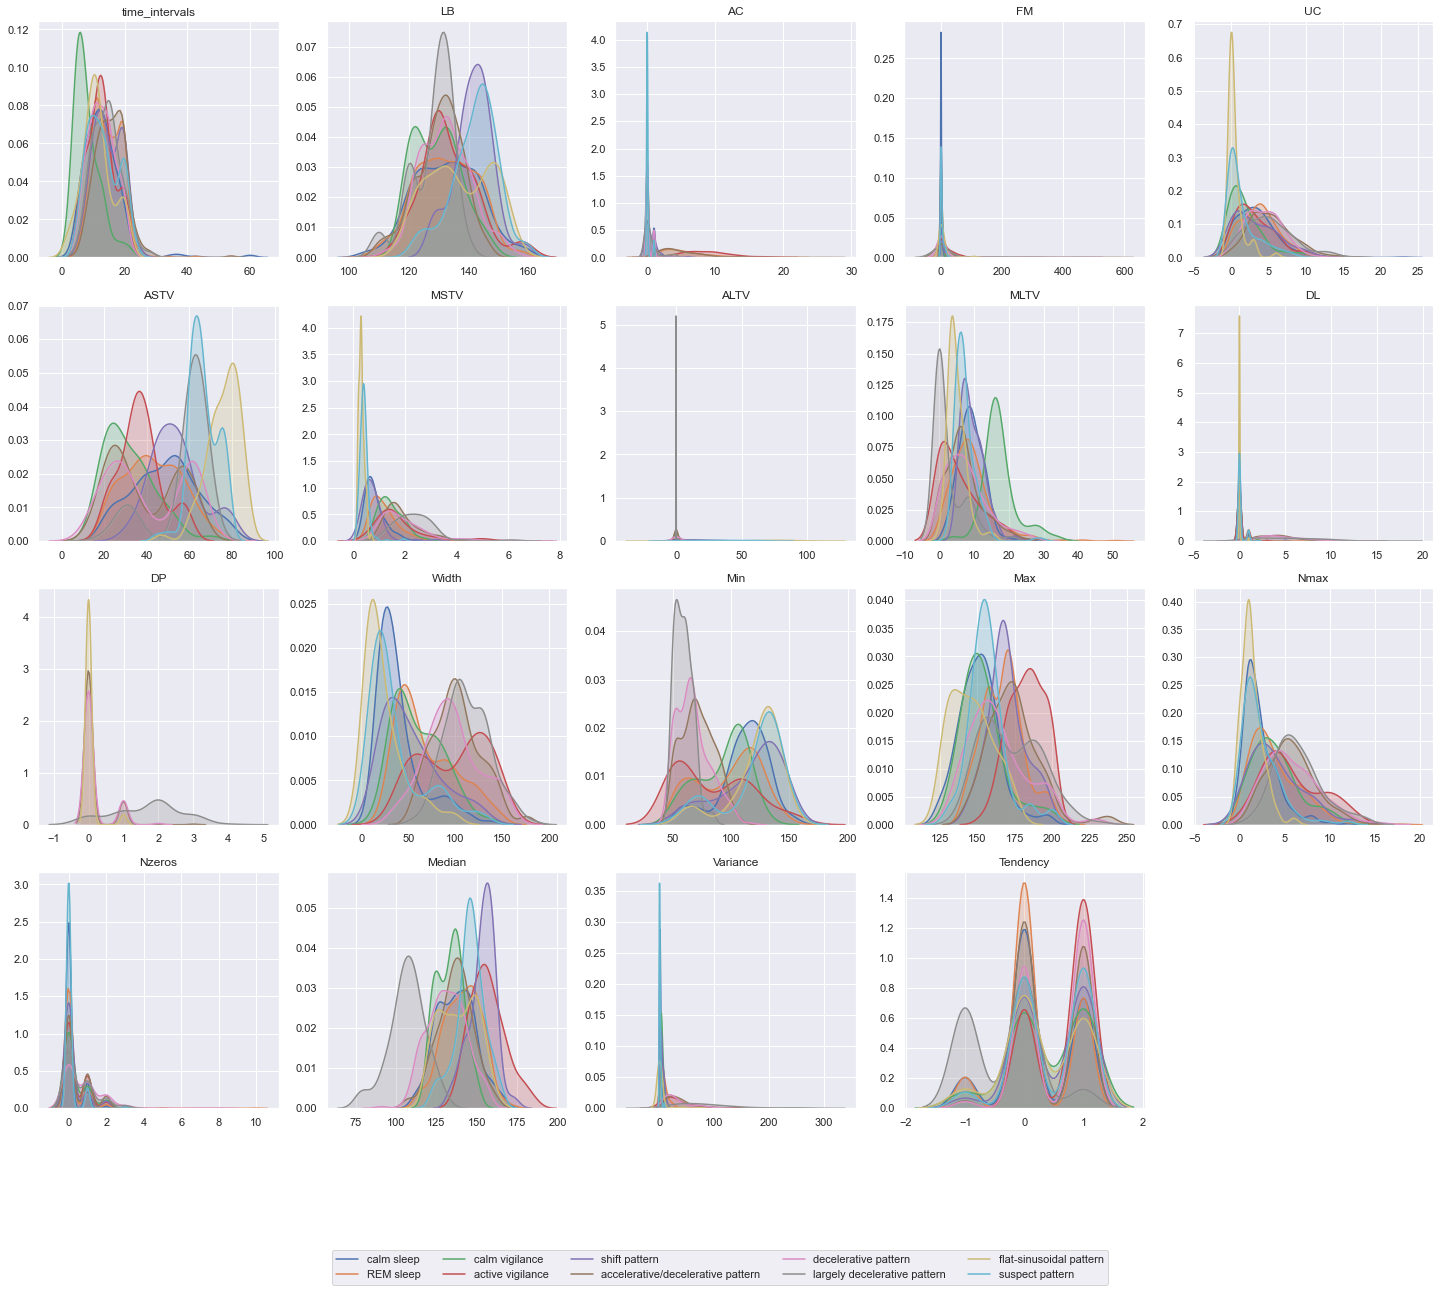

In [19]:
sns.set(color_codes=True)

def density_subplots(_df):
    fig, axes = plt.subplots(4, 5, figsize=(25, 20))
    axes[-1,-1].axis('off')

    i = 0
    j = 0

    grouped_by_class = _df.groupby('CLASS')

    for series in _df.loc[:, 'time_intervals':'Tendency'].iteritems():
        axes[i,j].title.set_text(series[0])
        for name, group in grouped_by_class:
            sns.kdeplot(group[series[0]], shade=True, ax=axes[i,j], legend=False)
        j += 1
        if j == 5:
            j = 0
            i += 1

    handles, _ = axes[-1,-2].get_legend_handles_labels()
    fig.legend(handles, classes_description_dict.values(),
               loc='lower center', ncol=5)
    plt.show()

density_subplots(df)

We can see in these density plots, that we have some features with
skewed distributions and low variance. We could use a transformation
to improve the contrast of these values among the 10 classes.

### Data cleaning and transformation

Let's apply a power transform, namely the [Yeo-Johnson transformation](https://en.wikipedia.org/wiki/Power_transform#Yeo%E2%80%93Johnson_transformation)
on our data. A power transform can be used when we want to stabilize variance,
make the data more normal distribution-like and we also want to improve the validity
of measures of association such as the correlation between variables. The Yeo-Johnson
transform seems to be the right pick as it can be used with zero and negative values also.

C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\krisz\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


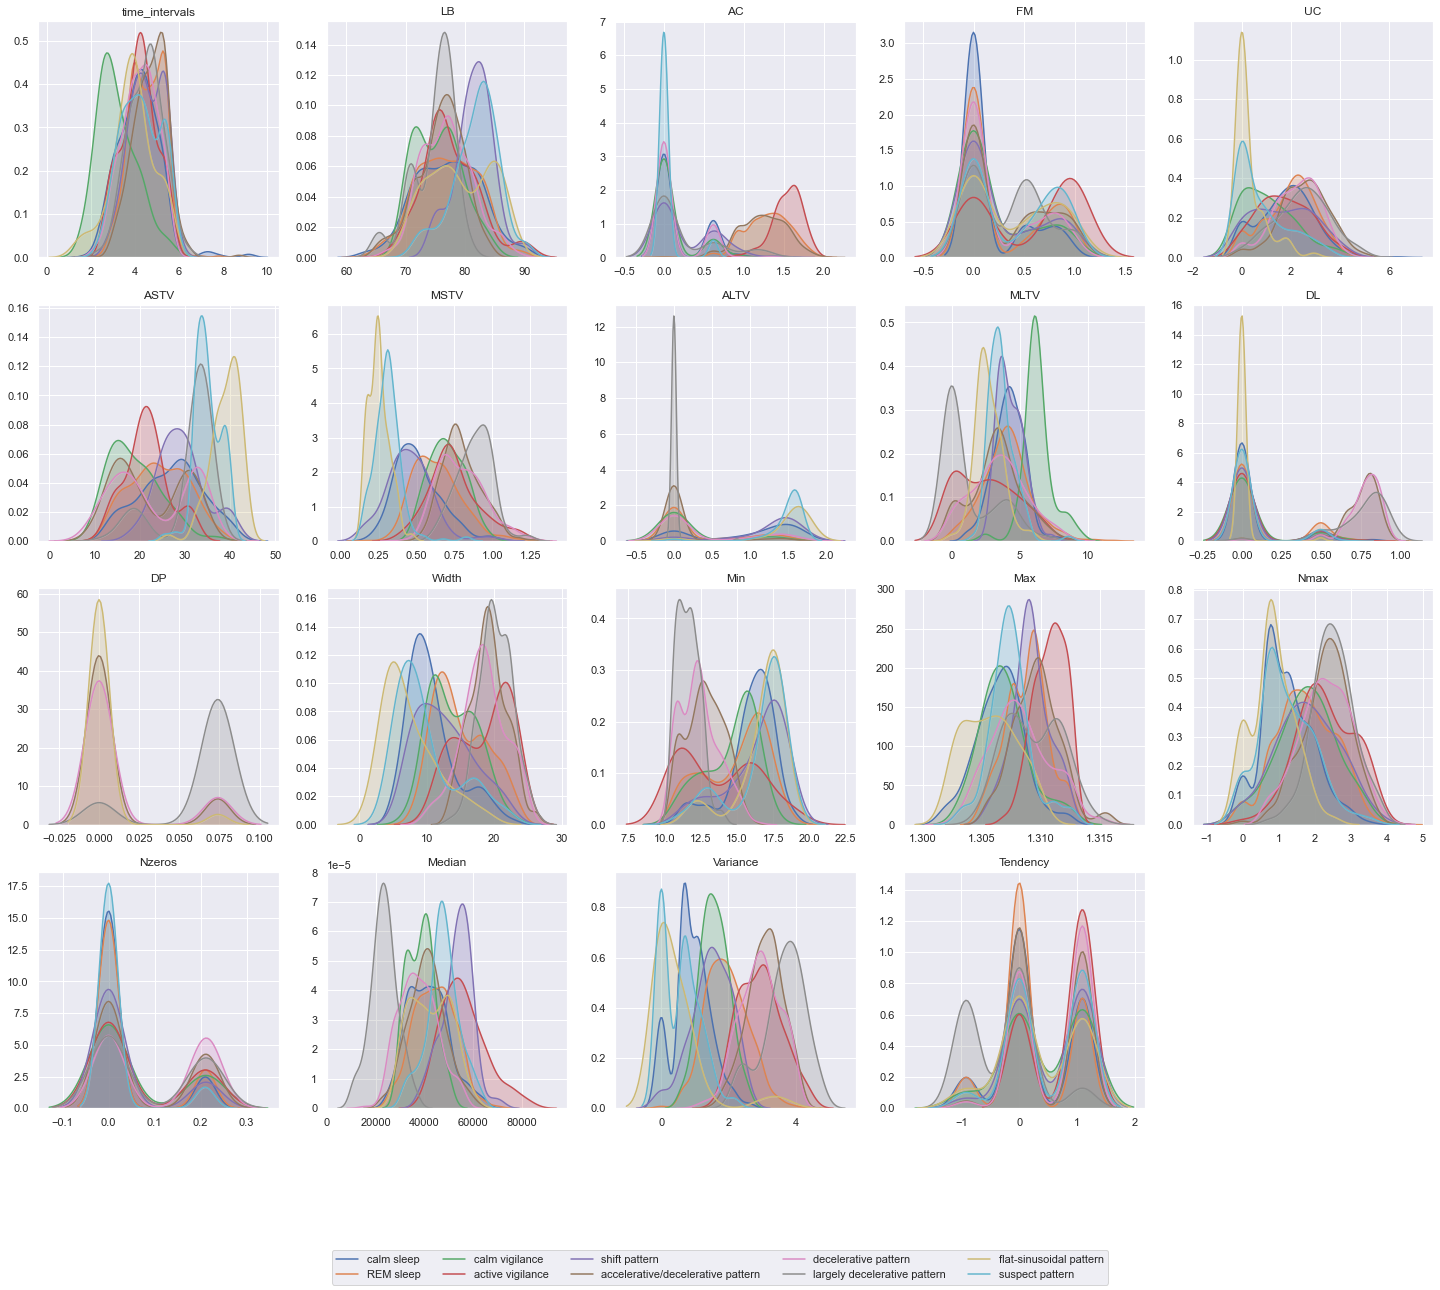

In [20]:
from sklearn.preprocessing import PowerTransformer

df_feature_view = df.loc[:, 'time_intervals':'Tendency']

pt = PowerTransformer(standardize=False)

new_df = pd.DataFrame(data=pt.fit_transform(df_feature_view),
                      index=df_feature_view.index, columns=df_feature_view.columns)

new_df['CLASS'] = df['CLASS']

density_subplots(new_df)

The `new_df` histograms tells us that the transformation somewhat corrected the
skewness of the features.

Let's build the final dataset from the `df` and `new_df` dataframes.
From the transformed dataset we will use the following features:
`AC`, `FM`, `ALTV`, `MSTV`, `MLTV`, `DL`, `DP`, `Nzeros`, `Nmax` and `Variance`.

The rest of the features will be the values from the original dataset.

In [21]:
final_df = df_feature_view.copy()

final_df['AC'] = new_df['AC']
final_df['FM'] = new_df['FM']
final_df['ALTV'] = new_df['ALTV']
final_df['MSTV'] = new_df['MSTV']
final_df['MLTV'] = new_df['MLTV']
final_df['DL'] = new_df['DL']
final_df['DP'] = new_df['DP']
final_df['Nzeros'] = new_df['Nzeros']
final_df['Nmax'] = new_df['Nmax']
final_df['Variance'] = new_df['Variance']

Let's see a correlation heatmap for our final dataframe.

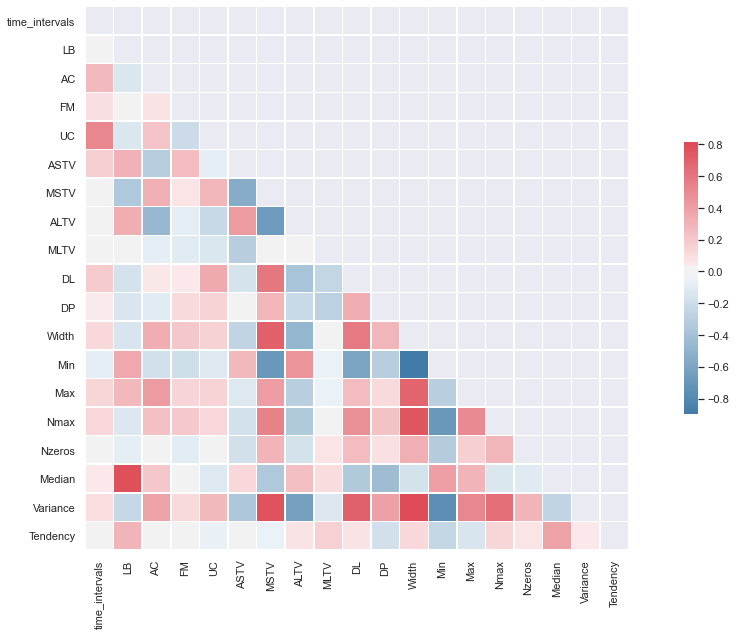

In [22]:
corr = final_df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, axes = plt.subplots(figsize=(20,10))

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlation heatmap shows strong relationship between the CTG
histogram features, as expected. Also the `Median` positively correlates
to the `LB` which makes sense. There are a couple of other
strong correlations, for example the `Variance` and the base.

Overall we can say that our features are kind of all over the place
in terms of correlation. Highly correlated features imply collinearity,
but further reducing the dimensionality would be hard without losing essential
information. Normally PCA would be a great choice to reduce the dimensionality, but
it is very much possible to lose too much information by using it in such an
inherently noisy dataset.

## Modeling

Now that we have our data prepared for modeling, we should
decide what kind of models we will go with.

We should categorize the problem using the following information:
* our recorded data has labels
* we don't want to predict unknown labels
* the labels are discrete
* we have more than 2 classes
* the classes are mutually exclusive

This means our problem is a multi-class classification problem,
which points us to the direction of supervised learning methods.

Next, let's see if we could use a support vector classifier.
**[Support vector machines](https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72)**
(SVMs) are discriminative classifiers defined by a separating hyperplane.
In other words, given labeled training data, the algorithm outputs an optimal
hyperplane which categorizes new examples. SVMs use kernel functions to
systematically find support vector classifiers in higher dimensions.
They are effective in already high dimensions.

Our dataset is relatively small, but that's not a problem for SVM.

At first glance, it seems like SVM could handle our classification problem.

Before doing anything else, in a supervised learning scenario
we should separate the dataframe to dataset and labels,
then split the data to training and test sets. We will use the 70-30 ratio.

In [23]:
dset = final_df
labels = df['CLASS']

from sklearn.model_selection import train_test_split

train_set, test_set,\
train_labels, test_labels = train_test_split(dset, labels, test_size=0.3,
                                             random_state=42)


Now we have our training and test set.

Let's see what kind of parameters we have to deal with:
* *kernel*
    * the kernel function is the core of the SVM
    * it can be *linear*, *polynomial* and *rbf*
    * the radial basis function (*rbf*) kernel seems to be the most appropriate because we have
        * relatively many classes with overlapping features - linear kernel does not work too well with that
        * relatively small dataset - *rbf* is better with smaller datasets
* *regularization*
    * a.k.a. *C* parameter
    * tells the SVM how much we want to avoid misclassification
* *gamma*
    * defines how far the influence of a single training example reaches
    * low gamma means *far*, high gamma means *close*

Finding an appropriate *C* and *gamma* parameter is not a trivial task.

Let's try to search for the best parameters from a parameter grid and evaluate
the performance of the best estimator.

In [24]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1e3, 1e5, 1e6],
              'gamma': [1, 0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6],
              'kernel': ['rbf'],
              'random_state': [42]}
grid_search = GridSearchCV(SVC(), param_grid, n_jobs=-1)
start_time = time.time()
grid_search.fit(train_set, train_labels)
print(f"Fitting took {time.time() - start_time} seconds")
print(f"Best params: {grid_search.best_params_}")

svm = grid_search.best_estimator_

svm_predictions = svm.predict(test_set)

from sklearn import metrics

print(metrics.classification_report(test_labels, svm_predictions))

print('Accuracy: ', metrics.accuracy_score(test_labels, svm_predictions))
print('Precision: ', metrics.precision_score(test_labels, svm_predictions, average='weighted'))
print('Recall: ', metrics.recall_score(test_labels, svm_predictions, average='weighted'))

Fitting took 15.474997997283936 seconds
Best params: {'C': 1000000.0, 'gamma': 1e-06, 'kernel': 'rbf', 'random_state': 42}
              precision    recall  f1-score   support

         1.0       0.85      0.80      0.82       118
         2.0       0.93      0.91      0.92       169
         3.0       0.68      0.88      0.77        17
         4.0       0.95      0.88      0.91        24
         5.0       0.74      0.83      0.78        24
         6.0       0.91      0.95      0.93        93
         7.0       0.91      0.94      0.93        80
         8.0       0.92      0.92      0.92        25
         9.0       0.57      0.80      0.67        15
        10.0       0.81      0.75      0.78        73

    accuracy                           0.87       638
   macro avg       0.83      0.86      0.84       638
weighted avg       0.88      0.87      0.87       638

Accuracy:  0.8714733542319749
Precision:  0.8760755290076895
Recall:  0.8714733542319749


We got roughly 87% accuracy, precision and recall, not too bad for a first try.
From the classification report we can see that the model did relatively
well on most classes, except on the calm vigilance (3rd) and
flat-sinusoidal pattern (9th) classes.

---
Maybe we can do better with a different model.

The next type of model that seems appropriate is a Random Forest classifier.
The **Random Forest** (RFC) is a forest which consists of *decision trees*.
Decision trees can be used for multi-class classification and they perform well
in high dimensions. Their disadvantage is that they are easily overfitted. However,
a forest of randomized decision trees, each having their own vote for the classification
can help to mitigate overfitting and increase accuracy.

Let's create and evaluate a Random Tree classifier!

In [25]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

rfc.fit(train_set, train_labels)

rfc_predictions = rfc.predict(test_set)

print(metrics.classification_report(test_labels, rfc_predictions))

print('Accuracy: ', metrics.accuracy_score(test_labels, rfc_predictions))
print('Precision: ', metrics.precision_score(test_labels, rfc_predictions, average='weighted'))
print('Recall: ', metrics.recall_score(test_labels, rfc_predictions, average='weighted'))

              precision    recall  f1-score   support

         1.0       0.86      0.89      0.88       118
         2.0       0.89      0.93      0.91       169
         3.0       0.68      0.76      0.72        17
         4.0       0.88      0.62      0.73        24
         5.0       0.79      0.46      0.58        24
         6.0       0.94      0.98      0.96        93
         7.0       0.94      0.97      0.96        80
         8.0       0.92      0.96      0.94        25
         9.0       0.82      0.93      0.87        15
        10.0       0.94      0.86      0.90        73

    accuracy                           0.89       638
   macro avg       0.87      0.84      0.84       638
weighted avg       0.89      0.89      0.89       638

Accuracy:  0.8949843260188087
Precision:  0.894166225909494
Recall:  0.8949843260188087


The time it took to fit the model was super fast and our results have slightly
improved compared to the SVM model, we achieved almost 90% accuracy.
Our RFC does much better on the 9th class, but it's still not good enough on the
calm vigilance (3rd) class. It also did a bit worse than SVM on the shift pattern (5th) class.

---
Let's try a 3rd type of classifier.

The **Multilayer Perceptron** is a fully connected neural network.
It consists of an input layer, one or more hidden layers and an output layer.
MLP classifier learns faster and performs well with scaled, but for now
let's keep the data as is.

In [26]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()
mlp = MLPClassifier(solver='lbfgs',
                    alpha=1e-4,
                    hidden_layer_sizes=(30,),
                    random_state=42,
                    max_iter=6000)
mlp.fit(train_set, train_labels)
print(f"Fitting took {time.time() - start_time} seconds")

mlp_predictions = mlp.predict(test_set)

print(metrics.classification_report(test_labels, mlp_predictions))

print('Accuracy: ', metrics.accuracy_score(test_labels, mlp_predictions))
print('Precision: ', metrics.precision_score(test_labels, mlp_predictions, average='weighted'))
print('Recall: ', metrics.recall_score(test_labels, mlp_predictions, average='weighted'))

Fitting took 20.586997509002686 seconds
              precision    recall  f1-score   support

         1.0       0.87      0.75      0.81       118
         2.0       0.93      0.91      0.92       169
         3.0       0.68      0.76      0.72        17
         4.0       0.87      0.83      0.85        24
         5.0       0.80      0.83      0.82        24
         6.0       0.89      0.95      0.92        93
         7.0       0.93      0.95      0.94        80
         8.0       0.85      0.92      0.88        25
         9.0       0.60      0.80      0.69        15
        10.0       0.78      0.81      0.79        73

    accuracy                           0.87       638
   macro avg       0.82      0.85      0.83       638
weighted avg       0.87      0.87      0.87       638

Accuracy:  0.8667711598746082
Precision:  0.8701432232688601
Recall:  0.8667711598746082


After playing with the hyperparameters of the MLP, we found that our dataset is small
enough for the L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) optimization
algorithm. Careful tuning of the alpha, size of hidden layers and maximum iterations
parameters made the model perform almost as well as our SVM model.

---
Now that we have 3 models that perform equally well on this dataset, let's try
to create an ensemble of these. A soft voting classifier could balance out
the individual weaknesses of our models. Soft voting would be better than hard voting,
because it takes into account how certain each estimator is, rather than just taking a
binary input.

Let's create new, unfitted models based on the parameters of the SVM,
RFC and MLP models we used, then adjust their weights based on their performance.

In [42]:
from sklearn.ensemble import VotingClassifier

svm_v = SVC(kernel='rbf',
            C=grid_search.best_params_['C'],
            gamma=grid_search.best_params_['gamma'],
            random_state=42,
            probability=True)

rfc_v = RandomForestClassifier(random_state=42)

mlp_v = MLPClassifier(solver='lbfgs',
                    alpha=1e-4,
                    hidden_layer_sizes=(30,),
                    random_state=42,
                    max_iter=6000)

voting_clf = VotingClassifier(
    estimators=[('svm', svm_v), ('rfc', rfc_v), ('mlp', mlp_v)],
    n_jobs=-1,
    voting='soft',
    weights=[1, 1.25, 0.75]
)

start_time = time.time()
voting_clf.fit(train_set, train_labels)
print(f"Fitting took {time.time() - start_time} seconds")

voting_predictions = voting_clf.predict(test_set)

print(metrics.classification_report(test_labels, voting_predictions))

print('Accuracy: ', metrics.accuracy_score(test_labels, voting_predictions))
print('Precision: ', metrics.precision_score(test_labels, voting_predictions, average='weighted'))
print('Recall: ', metrics.recall_score(test_labels, voting_predictions, average='weighted'))

Fitting took 18.10499906539917 seconds
              precision    recall  f1-score   support

         1.0       0.89      0.86      0.88       118
         2.0       0.92      0.93      0.93       169
         3.0       0.76      0.76      0.76        17
         4.0       1.00      0.75      0.86        24
         5.0       0.86      0.75      0.80        24
         6.0       0.91      0.99      0.95        93
         7.0       0.94      0.99      0.96        80
         8.0       0.92      0.92      0.92        25
         9.0       0.78      0.93      0.85        15
        10.0       0.90      0.85      0.87        73

    accuracy                           0.91       638
   macro avg       0.89      0.87      0.88       638
weighted avg       0.91      0.91      0.91       638

Accuracy:  0.9075235109717869
Precision:  0.908329559269462
Recall:  0.9075235109717869


With soft voting we reached almost 91% precision and accuracy, so
we can say that the voting classifier improved on the performance.

In order to reach an even better performance, we could use deep learning. The only
issue with that would be the size of our dataset. Deep learning requires a lot of
data, so without data augmentation we probably would not get better results from it
than with our voting classifier.

---
Now, let's see the NSP categories: normal, suspect and pathologic. We have only
3 classes here, so the task should be easier. Let's split the dataset again
for the NSP classification.

In [32]:
nsp_labels = df['NSP']

nsp_train_set, nsp_test_set,\
nsp_train_labels, nsp_test_labels = train_test_split(dset,
                                                     nsp_labels,
                                                     test_size=0.3,
                                                     random_state=42)

Let's try a Random Forest classifier for NSP classification. This model performed the best
on the 10-class problem, so it should perform well on the 3 class variety too.

In [33]:
from sklearn.ensemble import RandomForestClassifier

rfc_nsp = RandomForestClassifier(random_state=42)

rfc_nsp.fit(nsp_train_set, nsp_train_labels)

rfc_nsp_predictions = rfc_nsp.predict(nsp_test_set)

print(metrics.classification_report(nsp_test_labels, rfc_nsp_predictions))

print('Accuracy: ', metrics.accuracy_score(nsp_test_labels, rfc_nsp_predictions))
print('Precision: ', metrics.precision_score(nsp_test_labels, rfc_nsp_predictions, average='weighted'))
print('Recall: ', metrics.recall_score(nsp_test_labels, rfc_nsp_predictions, average='weighted'))

              precision    recall  f1-score   support

         1.0       0.95      0.98      0.97       496
         2.0       0.91      0.77      0.83       101
         3.0       0.90      0.93      0.92        41

    accuracy                           0.95       638
   macro avg       0.92      0.89      0.91       638
weighted avg       0.94      0.95      0.94       638

Accuracy:  0.945141065830721
Precision:  0.9440928868449036
Recall:  0.945141065830721


It performed pretty well, we reached almost 95% accuracy here.

## Conclusion

In part 1, we understood, explored and cleaned our dataset containing CTGs.
At the beginning of part 2, we further examined the features and checked the density plots
with respect to the 10-class problem. We tried to solve the low variance and skewed
distributions with a Yeo-Johnson transformation on the problematic features.
We examined the correlation heatmap in order to get a better understanding of
the relationships between the features.

We found 3 different, equally well-performing classification models for the 10-class problem
of our dataset. These were a Support Vector Machine (SVM), a Random Forest classifier and a
Multilayer Perceptron classifier. In order to further increase the performance we used
all three of them in an ensemble, called a Soft Voting classifier. This final
classification method reached almost 91% accuracy.

The 3-class classification problem was easier to crack with an appropriate
classification method, as a single Random Forest classifier
could easily reach 95% accuracy on our cleaned and transformed dataset.